Copyright (c) 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

---

# <font color="red">Train and Deploy Models from Massive Datasets: Credit Card Fraud Detection use-case</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---

# Overview:

Credit card fraud is a major source of losses for any merchant, and the prevalence of this form of payment combined with the increase in online transactions makes it an important issue to try to tackle.

However fraud is still a small fraction of all transactions and training a macine learning model for this purpose tends to require a vast amount of data.

In this notebook, we'll show how to work with Spark, a distributed computing framework which is available as a service on Oracle Cloud Infrastructure (OCI) as DataFlow; a fully managed Spark deployment.

We'll start with exploring a synthetic dataset of credit card transactions, developing Spark code on a subset of a very large dataset, engineering features and selecting a model, and then implement the model as a DataFlow Application, to run the model training on terabytes of data.

<a id="feature1"></a>
## Prerequisites

- Experience with the specific Topic: Intermediate.

- Professional experience: None

- The data generation part of this use case can be very time consuming, depending on the amount of data you wish to generate. We recommend the use of the shape with at least 8 OCPUs. To generate terabytes of data, we recommend using the maximum amount of OCPUs for the E3 Flex shape (64 cores) to run the tool; this would allow generating ~1.4TB of data in ~2h. To run this notebook, medium size datasets that can be generated in a few minutes is sufficient. When running the DataFlow run to train the final model, you should do so on the largest dataset.


## Objectives

In this notebook, we'll go over the datascience workflow from exploration to model deployment.

We'll explore a credit card transaction dataset, try models and evaluate their performance on this dataset, 
create Spark applications to run training and batch scoring on Oracle Cloud Infrastructure DataFlow, the Oracle serverless Spark platform, 
and deploy a model inference server callable via a REST endpoint.


---

## Contents:

- <a href='#use_case'>1. Fraud Detection Use Case</a>
    - <a href="#utilities">1.1. Utility Functions</a>
    - <a href="#dataset">1.2. Generate the Dataset</a>
    - <a href="#store_data">1.3. Store Dataset on Object Storage</a>
    - <a href="#explore">1.4. Exploring the Dataset</a>
        - <a href="#customer_info">1.4.1. Customer Information</a>
            - <a href="#age">1.4.1.1. Customer Age</a>
            - <a href="#gender">1.4.1.2. Customer Gender</a>
            - <a href="#city_population">1.4.1.3. Customer City Population</a>
        - <a href="#transaction_info">1.4.2. Transaction Information</a>
            - <a href="#day_of_week">1.4.2.1. Day of Week</a>
            - <a href="#weekend">1.4.2.2. Weekend or Weekday</a>
            - <a href="#month_of_year">1.4.2.3. Month of the Year</a>
            - <a href="#time_of_day">1.4.2.4. Time of Day</a>
            - <a href="#amount">1.4.2.5. Transaction Amount</a>
            - <a href="#category">1.4.2.6. Merchant Category</a>
            - <a href="#distance">1.4.2.7. Distance to Merchant</a>
    - <a href="#features">1.5. Feature Engineering</a>
        - <a href="#build_features">1.5.1. Build the feature set</a>
        - <a href="#split_set">1.5.2. Split Train and Test sets</a>
        - <a href="#rebalance">1.5.3. Rebalance Classes</a>
        - <a href="#eval_helper">1.5.4. Model Evaluation helper</a>
    - <a href="#model_selection">1.6. Model Selection</a>
        - <a href="#lr">1.6.1. Logistic Regression Model</a>
        - <a href="#dt">1.6.2. Decision Tree Classifier Model</a>
        - <a href="#rf">1.6.3. Random Forest Classifier</a>
        - <a href="#gbt">1.6.4. Gradient Boosted Trees</a>
    - <a href="#df_training">1.7. Running Training on OCI DataFlow</a>
        - <a href="#training_script">1.7.1. DataFlow Training Application script</a>
        - <a href="#test_training">1.7.2. Test the DataFlow Application script locally</a>
        - <a href="#training_app">1.7.3. Create the DataFlow Application</a>
        - <a href="#training_run">1.7.4. Create a DataFlow Training Run</a>
        - <a href="#edit_script">1.7.5. Editing DataFlow applications</a>
    - <a href="#df_scoring">1.8. Create a Batch Scoring Application</a>
        - <a href="#scoring_script">1.8.1. DataFlow Batch Scoring Application script</a>
        - <a href="#scoring_run">1.8.2. Create a DataFlow Run for scoring</a>
    - <a href="#model_cat">1.9. Create a Model in Model Catalog</a>
        - <a href="#artifact">1.9.1. Prepare the Model Artifact for Model Catalog</a>
        - <a href="#model_script">1.9.2. Create the Inference Model script</a>
        - <a href="#pull_model">1.9.3. Get the trained model into the model deployment folder</a>
        - <a href="#save_to_cat">1.9.4. Save the model into Model Catalog</a>
        - <a href="#test_model">1.9.5. Test the model locally</a>
    - <a href="#md">1.10. Deploy the model</a>
        - <a href="#md_create">1.10.1 Create a Model Deployment and Endpoint</a>
        - <a href="#test_md">1.10.2 Test the Model Deployment Endpoint</a>
- <a href="#reference">References</a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

In [23]:
# make sure we have ads 2.6.1
!pip install -U oracle-ads~=2.6.1

In [1]:
from datetime import datetime
datetime.now()

datetime.datetime(2022, 6, 16, 2, 20, 21, 494611)

In [24]:
import ads
import json
import matplotlib.pyplot as plt
import numpy as np
import oci
import ocifs
import os
import pandas as pd
import pyspark
import re
import requests
import sys

from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
from ads.dataflow.dataflow import DataFlow
from ads.model.deployment import ModelDeployer

from datetime import datetime
from glob import glob

from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.functions import vector_to_array

from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType


<a id='use_case'></a>
# 1. Fraud Detection Use Case

In this notebook, we'll first demonstrate how to export data generated locally to object storage. 

We'll then explore a sub-sample of a large dataset and engineer features to be used to train a model using PySpark in the DataScience Notebook. 

We'll then train different models from the Spark MLLib library to select the best performing model. To do this, we'll train the model on the smaller dataset. 

Once features are defined and a model is selected, we'll use the code to create a DataFlow Application, and run it on our large dataset from the Data Science Notebook.




<a id="utilities"></a>
## 1.1. Utility Functions

In this section, we'll define a utility function to get a Spark session. The way to obtain the Spark session depends on whether the code runs locally, in a Data Science Notebook or DataFlow.

In [3]:
def is_in_oci():
    return os.environ.get("HOME") == "/home/dataflow" or os.environ.get("HOME") == "/home/datascience"

def get_spark_session(
        app_name, 
        file_location=None, 
        profile_name=None, 
        spark_config={}
    ):
    """
    Get a Spark session in a way that supports running locally or in Data Flow.
    """
    
    # If we are in DataFlow or DataScience, we assume the instance uses Instance Principal 
    # for authorization, and we can create a Spark Session Builder without config
    if is_in_oci():
        spark_builder = SparkSession.builder.appName(app_name)
        
    # If we run on a local machine, we need to provide authentication from the OCI config
    else:
        # Import OCI.
        try:
            import oci
        except:
            raise Exception(
                "You need to install the OCI python library to test locally"
            )
        # Use defaults for anything unset.
        if file_location is None:
            file_location = oci.config.DEFAULT_LOCATION
        if profile_name is None:
            profile_name = oci.config.DEFAULT_PROFILE

        # Load the config file.
        try:
            oci_config = oci.config.from_file(
                file_location=file_location, profile_name=profile_name
            )
        except Exception as e:
            print("You need to set up your OCI config properly to run locally")
            raise e
        conf = SparkConf()
        conf.set("fs.oci.client.auth.tenantId", oci_config["tenancy"])
        conf.set("fs.oci.client.auth.userId", oci_config["user"])
        conf.set("fs.oci.client.auth.fingerprint", oci_config["fingerprint"])
        conf.set("fs.oci.client.auth.pemfilepath", oci_config["key_file"])
        conf.set(
            "fs.oci.client.hostname",
            "https://objectstorage.\{0\}.oraclecloud.com".format(oci_config["region"]),
        )
        spark_builder = SparkSession.builder.appName(app_name).config(conf=conf)

    # Add in extra configuration.
    for key, val in spark_config.items():
        spark_builder.config(key, val)

    # Create the Spark session.
    session = spark_builder.getOrCreate()
    return session
        

Configure resource principal for the local Spark context. This allow access to things like Object Storage seamlessly.

In [4]:
!odsc core-site config -o -a resource_principal

The core-site.xml is being written to /home/datascience/spark_conf_dir/core-site.xml


<a id="dataset"></a>
## 1.2. Generate the Dataset

In this section, we'll go over how to generate a synthetic credit card transaction dataset, using the project at [https://github.com/namebrandon/Sparkov_Data_Generation](https://github.com/namebrandon/Sparkov_Data_Generation)

Proceed as follows:

- If you are running this in a DataScience environment, go to the Launcher and open a Terminal window

- In the Terminal window, run the following:

- Clone the data generation repository:

    ```bash
    git clone https://github.com/namebrandon/Sparkov_Data_Generation
    ```


- Get into the Sparkov_Data_Generation folder and install the requirements:

    ```bash
    cd Sparkov_Data_Generation
    pip install -r requirements.txt
    ```
    

- Generate a large training dataset with 10000 customers and transactions over a 1 year period:

    ```bash
    python datagen.py -n 10000 -o "data/training set/large" 01-01-2012 12-31-2012
    ```


- Generate a medium scoring dataset with 1000 customers and transactions over a 2 year period:

    ```bash
    python datagen.py -n 1000 -o "data/scoring set/medium" 01-01-2012 12-31-2013
    ```


- To generate a very large training dataset of ~1.5TB, ~5.5B records, to use with the DataFlow application, the following setting were used:

    ```bash
    python datagen.py -n 250000 -o "data/training set/xlarge" 01-01-2000 12-31-2020
    ```
    This will take ~2h on a 64cores / 128 threads VM and require you have selected at least 2000GB of storage when provisioning the notebook session.



In [5]:
# Edit the location of the data folder according to where you saved the data
data_folder = '/home/datascience/workspace/data/Sparkov_Data_Generation/data/'
# the file pattern insures we do not pick up the 'customers.csv' file 
# while picking up all the *male*.csv and *female*.csv files
file_pattern = 'training set/medium/*male*.csv'
# file_pattern = 'training set/large/*male*.csv'

<a id="store_data"></a>
## 1.3. Store Dataset on Object Storage

Make sure you have created an object storage bucket in your compartment before running the following cells, and edit the tenancy_name and bucket_name

In [6]:
tenancy_namespace = 'bigdatadatasciencelarge'
bucket_name = 'fraud-detection-data'

def store_on_oss(tenancy_namespace, bucket_name, data_folder, file_pattern):
    if is_in_oci():
        signer = oci.auth.signers.get_resource_principals_signer()
        object_storage_client = oci.object_storage.ObjectStorageClient(config={}, signer=signer)
    else:
        config = oci.config.from_file()
        object_storage_client = oci.object_storage.ObjectStorageClient(config)

    files = glob(data_folder + file_pattern)
    file_count = len(files)
    for i, file in enumerate(files):
        print(f'{i + 1}/{file_count} copy: {file}')
        filename = file.replace(data_folder, '')
        print(f'{i + 1}/{file_count} to: {bucket_name}@{tenancy_namespace}/{filename}')
        with open(file, 'r') as f:
            put_object_response = object_storage_client.put_object(
                namespace_name=tenancy_namespace,
                bucket_name=bucket_name,
                object_name=filename,
                put_object_body=f
            )
        # sign in every so often because the auth has a timeout
        if i == 100:
            signer = oci.auth.signers.get_resource_principals_signer()
            object_storage_client = oci.object_storage.ObjectStorageClient(config={}, signer=signer)

In [7]:
# store_on_oss(tenancy_namespace, bucket_name, data_folder, file_pattern)

<a id="explore"></a>
## 1.4. Exploring the Dataset

We'll start by loading our large dataset, and sample a subset for exploration.

In [8]:
sc = get_spark_session(app_name="CC_Fraud_Detection")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [9]:
sc.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
cc_df = sc.read.option("delimiter", "|").csv(data_folder + file_pattern, header=True, inferSchema=True)


Let's have a look at the schema

In [10]:
cc_df.printSchema()

root
 |-- ssn: string (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- acct_num: long (nullable = true)
 |-- profile: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- trans_date: string (nullable = true)
 |-- trans_time: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merchant: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)



and the distribution of the data

In [11]:
cc_df.count()

22/06/15 18:48:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


1633210

In [12]:
cc_df.groupBy('is_fraud').count().show(2)

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   9357|
|       0|1623853|
+--------+-------+



In [13]:
cc_df_sample = cc_df.sample(False, 0.05)

In [14]:
cc_df_sample.count()

81466

In [15]:
cc_df_sample.groupBy('is_fraud').count().show(2)

+--------+-----+
|is_fraud|count|
+--------+-----+
|       1|  478|
|       0|80988|
+--------+-----+



Here we see that we have a similar distribution of fraudulent transactions in both the sample and the full dataset, so we can use our sample as a representative dataset.

<a id="customer_info"></a>
### 1.4.1. Customer Information

The first 16 columns correspond to the customer profile:
- ssn: string (nullable = true)
- cc_num: long (nullable = true)
- first: string (nullable = true)
- last: string (nullable = true)
- gender: string (nullable = true)
- street: string (nullable = true)
- city: string (nullable = true)
- state: string (nullable = true)
- zip: integer (nullable = true)
- lat: double (nullable = true)
- long: double (nullable = true)
- city_pop: integer (nullable = true)
- job: string (nullable = true)
- dob: string (nullable = true)
- acct_num: long (nullable = true)
- profile: string (nullable = true)

Looking at how the data is generated, we can see that any customer may have fraudulent transactions, so that `ssn`, `acct_num`, `name` or `job` may not be relevant.

Each customer has a specific profile, which determine the type, amount and frequency of transactions. The profiles consider `gender`, `age` and type of city (urban or rural), so gender, age and city information are relevant columns.

In each profile, there is also a flag determining if the customer travels or not. Note that at the time of writing (v1.0) the generator code does not take this flag into account)

Since most machine learning models expect numeric values as input, and we have many string values columns, we will need to encode those.

- `gender` is `male` or `female` so it can essily be 1-hot encoded.
- `street`, `city`, `state` are difficult to 1-hot encode as this assumes a fixed set of categories. `zip` actually encodes these values fairly accurately so we could use that alone, 
however despites being an integer, it is technically categorical data, not numeric.
- `long`, `lat` pair of values is actually a better representation of the city location and potential area for fraud. Distance to the merchant is the actual metric of interest in this model.
- `dob` (date of birth) is useful information, but customer profiles actually use `age`, so we'll compute `age` from `dob`.
- `city_pop` defines whether a city is urban or rural, which is part of the profiles.

In conclusion, we should:

- keep and 1-hot encode `gender`
- use `long` and `lat` to compute distance to the merchant
- use `city_pop` to represent city area
- drop the rest that is not relevant to this dataset
    
Note: in a real-life fraud detection dataset, job, ssn or account numbers may be relevant. They just happen to be random and not used to determine fraud in this dataset.
    


<a id="age"></a>
#### 1.4.1.1. Customer Age

Let's have a look at the customer attributes, starting with age:

<AxesSubplot:ylabel='Frequency'>

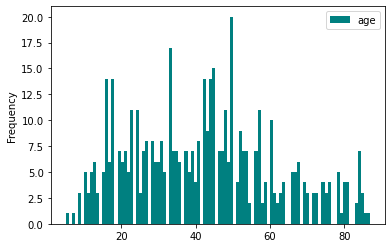

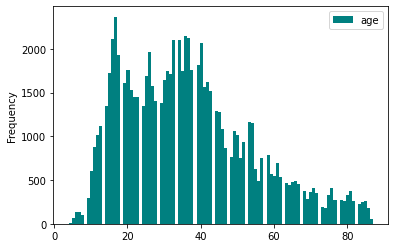

In [16]:
cc_df_sample.filter(col('is_fraud') == 1)\
    .withColumn('age',floor(datediff(col('trans_date'), to_date(col('dob'), 'yyyy-mm-dd'))/365.25))\
    .select('age')\
    .toPandas().plot.hist(by='age', bins=100)    

cc_df_sample.filter(col('is_fraud') == 0)\
    .withColumn('age',floor(datediff(col('trans_date'), to_date(col('dob'), 'yyyy-mm-dd'))/365.25))\
    .select('age')\
    .toPandas().plot.hist(by='age', bins=100)    


<a id="gender"></a>
#### 1.4.1.2. Customer Gender


<AxesSubplot:title={'center':'legitimate'}, ylabel='count'>

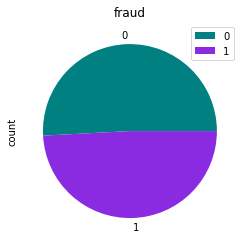

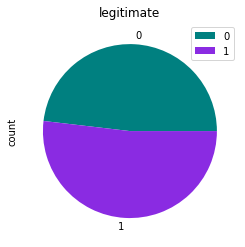

In [17]:
cc_df_sample.filter(col('is_fraud') == 1)\
    .withColumn('gender',when((col('gender') == 'M'),1).when((col('gender') == 'F'),0).otherwise(-1))\
    .select('gender')\
    .groupBy('gender')\
    .count()\
    .toPandas()[['gender', 'count']].plot.pie(y='count', title='fraud')

cc_df_sample.filter(col('is_fraud') == 0)\
    .withColumn('gender',when((col('gender') == 'M'),1).when((col('gender') == 'F'),0).otherwise(-1))\
    .select('gender')\
    .groupBy('gender')\
    .count()\
    .toPandas()[['gender', 'count']].plot.pie(y='count', title='legitimate')

<a id="city_population"></a>
#### 1.4.1.3. Customer City Population


<AxesSubplot:ylabel='Frequency'>

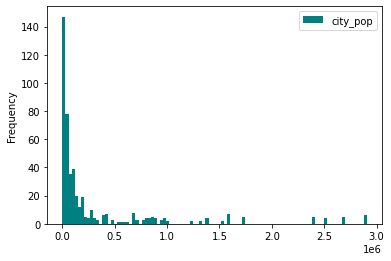

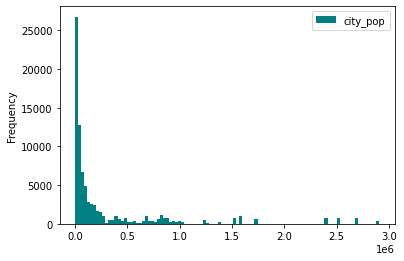

In [18]:
cc_df_sample.filter(col('is_fraud') == 1)\
    .select('city_pop')\
    .toPandas().plot.hist(by='city_pop', bins=100)

cc_df_sample.filter(col('is_fraud') == 0)\
    .select('city_pop')\
    .toPandas().plot.hist(by='city_pop', bins=100)

<a id="transaction_info"></a>
### 1.4.2. Transaction Information

The next 10 columns is the transaction information with the label `is_fraud`:
- trans_num: string (nullable = true)
- trans_date: string (nullable = true)
- trans_time: string (nullable = true)
- unix_time: integer (nullable = true)
- category: string (nullable = true)
- amt: double (nullable = true)
- is_fraud: integer (nullable = true)
- merchant: string (nullable = true)
- merch_lat: double (nullable = true)
- merch_long: double (nullable = true)

Let's have a look at the transaction columns to see what may be relevant:



<a id="day_of_week"></a>
#### 1.4.2.1. Day of Week

First, let's look for patterns of fraudulent transactions vs. legitimate ones in the transaction date

<AxesSubplot:title={'center':'legitimate'}, xlabel='day_of_week'>

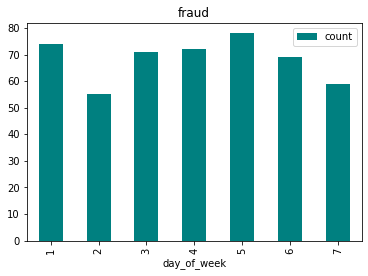

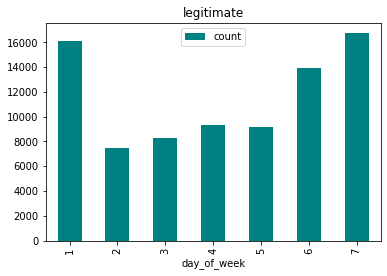

In [19]:
cc_df_sample.filter(col('is_fraud') == 1)\
    .withColumn('day_of_week', dayofweek(col('trans_date')))\
    .select('day_of_week')\
    .groupBy('day_of_week')\
    .count()\
    .sort('day_of_week')\
    .toPandas().plot.bar(y='count', x='day_of_week', title='fraud')

cc_df_sample.filter(col('is_fraud') == 0)\
    .withColumn('day_of_week', dayofweek(col('trans_date')))\
    .select('day_of_week')\
    .groupBy('day_of_week')\
    .count()\
    .sort('day_of_week')\
    .toPandas().plot.bar(y='count', x='day_of_week', title='legitimate')


Day of the week seem to have some relevance although it may just be our sample.

<a id="weekend"></a>
#### 1.4.2.2. Weekend or Weekday

Let's now look if fraud is more prevalent on weekend or weekdays

<AxesSubplot:title={'center':'legitimate'}, ylabel='count'>

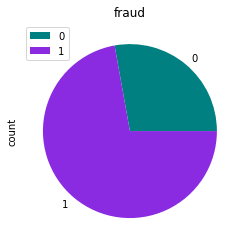

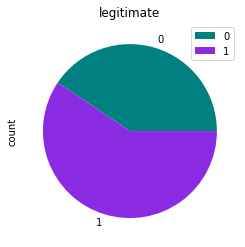

In [20]:
cc_df_sample.filter(col('is_fraud') == 1)\
    .withColumn('is_weekend', dayofweek(col("trans_date")).isin([1,7]).cast("int"))\
    .select('is_weekend')\
    .groupBy('is_weekend')\
    .count()\
    .toPandas()[['is_weekend', 'count']].plot.pie(y='count', title='fraud')
cc_df_sample.filter(col('is_fraud') == 0)\
    .withColumn('is_weekend', dayofweek(col("trans_date")).isin([1,7]).cast("int"))\
    .select('is_weekend')\
    .groupBy('is_weekend')\
    .count()\
    .toPandas()[['is_weekend', 'count']].plot.pie(y='count', title='legitimate')

<a id="month_of_year"></a>
#### 1.4.2.3. Month of the Year

Let's now look at the month of the year

<AxesSubplot:title={'center':'legitimate'}, xlabel='month_of_year'>

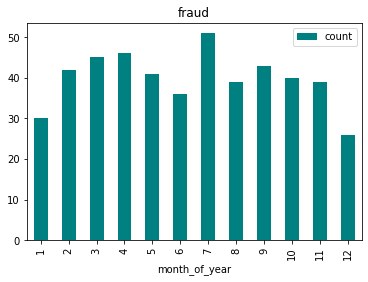

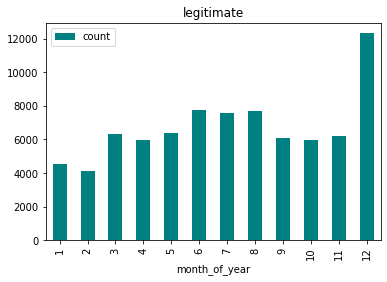

In [21]:
cc_df_sample.filter(col('is_fraud') == 1)\
    .withColumn('month_of_year', month(col('trans_date')))\
    .select('month_of_year')\
    .groupBy('month_of_year')\
    .count()\
    .sort('month_of_year')\
    .toPandas().plot.bar(y='count', x='month_of_year', title='fraud')

cc_df_sample.filter(col('is_fraud') == 0)\
    .withColumn('month_of_year', month(col('trans_date')))\
    .select('month_of_year')\
    .groupBy('month_of_year')\
    .count()\
    .sort('month_of_year')\
    .toPandas().plot.bar(y='count', x='month_of_year', title='legitimate')


We can see some relevance to the month of the year.

<a id="time_of_day"></a>
#### 1.4.2.4. Time of Day

Now let's look at the time of day:

<AxesSubplot:title={'center':'legitimate'}, xlabel='hour_of_day'>

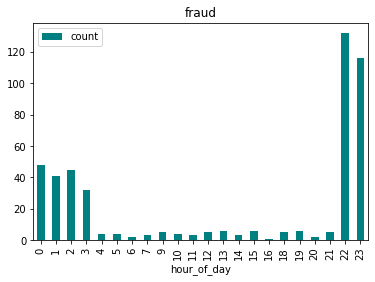

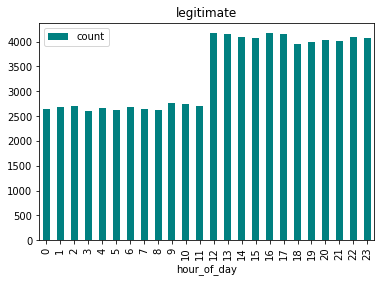

In [22]:
cc_df_sample.filter(col('is_fraud') == 1)\
    .withColumn('hour_of_day', hour(col('trans_time')))\
    .select('hour_of_day')\
    .groupBy('hour_of_day')\
    .count()\
    .sort('hour_of_day')\
    .toPandas().plot.bar(y='count', x='hour_of_day', title='fraud')

cc_df_sample.filter(col('is_fraud') == 0)\
    .withColumn('hour_of_day', hour(col('trans_time')))\
    .select('hour_of_day')\
    .groupBy('hour_of_day')\
    .count()\
    .sort('hour_of_day')\
    .toPandas().plot.bar(y='count', x='hour_of_day', title='legitimate')


<a id="amount"></a>
#### 1.4.2.5. Transaction Amount

Let's see what other columns may be relevant. Let's look at the amount distribution:

<AxesSubplot:ylabel='Frequency'>

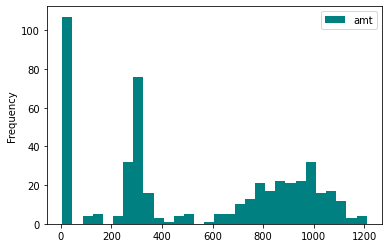

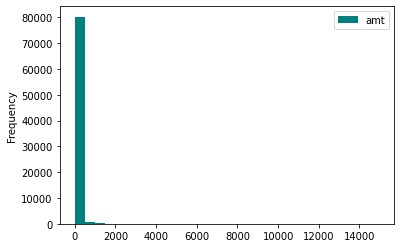

In [23]:
cc_df_sample.filter(col('is_fraud') == 1)\
    .select('amt')\
    .toPandas().plot.hist(by='amt', bins=30)

cc_df_sample.filter(col('is_fraud') == 0)\
    .select('amt')\
    .toPandas().plot.hist(by='amt', bins=30)


Amount is definitely a factor, so we'll keep this column

<a id="category"></a>
#### 1.4.2.6. Merchant Category

Let's look at the `category` column:

<AxesSubplot:title={'center':'legitimate'}, xlabel='category'>

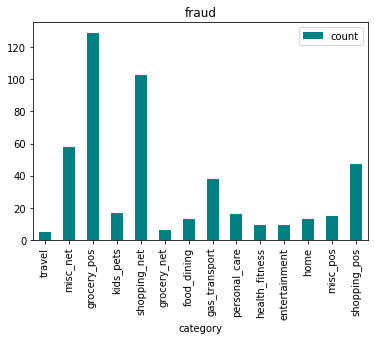

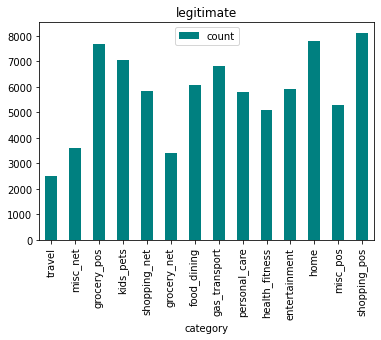

In [24]:
cc_df_sample.filter(col('is_fraud') == 1)\
    .select('category')\
    .groupBy('category')\
    .count()\
    .toPandas().plot.bar(y='count', x='category', title='fraud')

cc_df_sample.filter(col('is_fraud') == 0)\
    .select('category')\
    .groupBy('category')\
    .count()\
    .toPandas().plot.bar(y='count', x='category', title='legitimate')


It also seem to carry some information about fraud, so we'll use the column, although we will need to encode it.

<a id="distance"></a>
#### 1.4.2.7. Distance to Merchant

Let's look at the distance to the merchant. For this, we will need a small helper function to compute distance from geo coordinates

In [25]:
def distance(lat, long, merch_lat, merch_long):

    s_lat, s_lng, e_lat, e_lng = float(lat), float(long), float(merch_lat), float(merch_long)

    # approximate radius of earth in km
    R = 6373.0

    s_lat = s_lat*np.pi/180.0                      
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  

    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

    return float(2 * R * np.arcsin(np.sqrt(d)))

In [26]:
distance_udf = udf(lambda lat, long, merch_lat, merch_long: distance(lat, long, merch_lat, merch_long), FloatType())

In [27]:
cc_df_sample = cc_df_sample.withColumn("distance", distance_udf(col('lat'), col('long'), col('merch_lat'), col('merch_long')))

<AxesSubplot:ylabel='Frequency'>

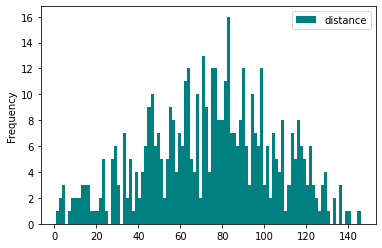

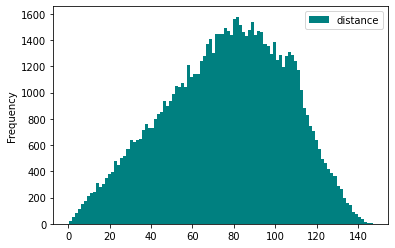

In [28]:
cc_df_sample.filter(col('is_fraud') == 1)\
    .select('distance')\
    .toPandas().plot.hist(by='distance', bins=100) 
cc_df_sample.filter(col('is_fraud') == 0)\
    .select('distance')\
    .toPandas().plot.hist(by='distance', bins=100) 

<a id="features"></a>
## 1.5. Feature Engineering

Now we identified relevant features, we can write up a single function for feature engineering that includes the necessary transforms.

This includes the 1-hot encoding for the `category` column we have not worked on yet.

<a id="build_features"></a>
### 1.5.1 Build the feature set

In [29]:
def create_feature_columns(df):
    # Augments the dataset with features we identified
    
    # drop unneeded columns
    df = df.drop('ssn', 'cc_num', 'first', 'last', 'street', 'city', 'state', 
                 'zip', 'job', 'acct_num', 'profile', 'trans_num', 'unix_time', 
                 'merchant')

    # transaction date and time features
    df = df.withColumn('day_of_week', dayofweek(col('trans_date')))
    df = df.withColumn('month_of_year', month(col('trans_date')))
    df = df.withColumn('hour_of_day', hour(col('trans_time')))
    df = df.withColumn('is_weekend', col('day_of_week').isin([1,7]).cast('int'))
    
    # distance
    distance_udf = udf(lambda lat, long, merch_lat, merch_long: distance(lat, long, merch_lat, merch_long), FloatType())
    df = df.withColumn("distance", distance_udf(col('lat'), col('long'), col('merch_lat'), col('merch_long')))
    
    # customer age and gender
    df = df.withColumn('age', floor(datediff(col('trans_date'), to_date(col('dob'), 'yyyy-mm-dd'))/365.25))
    df = df.withColumn('gender', when((col('gender') == 'M'), 1).when((col('gender') == 'F'), 0).otherwise(-1))
    
    # drop no longer used columns
    df = df.drop('dob', 'trans_date', 'trans_time')

    return df

def create_feature_encoding_pipeline(df):
    # Create a pipeline model encoding categorica features
    # which can be re-used to evaluate the model
    
    # 1-hot encode merchant category
    stringIndexer = StringIndexer(inputCol='category', outputCol='category_index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=['category_classVec'])
    
    stages = [stringIndexer, encoder]
    
    numeric_columns = [col[0] for col in df.dtypes if col[1] in ['int', 'double'] and col[0] != 'is_fraud']
    assembler_inputs = ['category_classVec'] + numeric_columns
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
    stages += [assembler]
    
    # put together the pipeline with the indexer, encoder and vector assembler
    pipeline = Pipeline(stages=stages)
    # fit the pipeline with the dataset
    pipeline_model = pipeline.fit(df)
    return pipeline_model

def encode_features(df, pipeline_model):
    df = pipeline_model.transform(df)
    df = df.drop('category_classVec')    
    return df
    

Putting it all together:

In [30]:
df2 = create_feature_columns(cc_df_sample)
pipeline_model = create_feature_encoding_pipeline(df2)
df2 = encode_features(df2, pipeline_model)

Now we have a dataset with the encoded features as a vector in the `features` column

In [31]:
df2.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- distance: float (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month_of_year: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- age: long (nullable = true)
 |-- category_index: double (nullable = false)
 |-- features: vector (nullable = true)



<a id="split_set"></a>
### 1.5.1. Split Train and Test sets

First let's split our dataset into train and test subsets, with a ratio of 80:20

In [32]:
train, test = df2.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 65343


Test Dataset Count: 16123


<a id="rebalance"></a>
### 1.5.2. Rebalance Classes

We saw early on that fraud amounted for about 1% of transactions, so we should rebalance our dataset to give the fraud cases more weight.


In [33]:
train_downsampled = train.sampleBy('is_fraud',
                                    fractions = {
                                         1: 1,
                                         0: 0.05
                                     }, seed= 1234)
train_downsampled.groupBy('is_fraud').count().orderBy('is_fraud').show(2)

+--------+-----+
|is_fraud|count|
+--------+-----+
|       0| 3290|
|       1|  402|
+--------+-----+



In [34]:
test_downsampled = test.sampleBy('is_fraud',
                                    fractions = {
                                         1: 1,
                                         0: 0.05
                                     }, seed= 1234)
test_downsampled.groupBy('is_fraud').count().orderBy('is_fraud').show(2)

+--------+-----+
|is_fraud|count|
+--------+-----+
|       0|  837|
|       1|   76|
+--------+-----+



<a id="eval_helper"></a>
### 1.5.3. Model Evaluation helper

To evaluate the performance of our model, we'll look at the receiver operating characteristic (ROC) curve, the Precision / Recall curve, and the confusion matrix, which give us indications about rates of false positives and false negatives.

The next cell is a helper function to perform these function, which we will use for all our models.

In [61]:
def eval_model(results, data):
    
    preds = results.transform(data)
    y_preds = preds.select('prediction').rdd.keys().collect()
    y_score = preds.select(vector_to_array("probability")[1]).rdd.keys().collect()
    y = preds.select("is_fraud").rdd.keys().collect()
    fpr, tpr, _ = roc_curve(y, y_score)
    prec, recall, _ = precision_recall_curve(y, y_score)    
    cm = confusion_matrix(y, y_preds)
    print(f"ROC area under curve Score: {roc_auc_score(y, y_score)}")
    pr = np.array([prec, recall]).T
    pr = pr[pr[:,0].argsort()]
    print(f"PR area under curve Score: {auc(pr[:,0], pr[:,1])}")
    print(f"Confusion Matrix:")
    print(cm)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm).plot()


The helper function provides an assessment of the model looking at a few metrics:

- The model decision function provides a way to introspect the ability of the classifier at different thresholds or steps of fitting.
- The Receiver Operating Characteristic (ROC) Area Under the Curve (AUC) provides a single metric measuring the area under the 
    ROC curve. The ROC curve looks at False Positive Rate vs. True Positive Rate across the decision function. 
- The Confusion Matrix shows the number of True Positive, True Negative, False Positive and False Negative, that is, the number of 
    predictions that were correctly assigned to True or False as well as incorrectly classified. 
- The Precision / Recall curve provides another way to look at model performance. Precision is the ratio of
    correctly predicted fraudulent transactions over the number of predicted fraudulent transactions. Recall is the ratio of 
    correctly predicted fraudulent transactions over the number of fraudulent transactions in the dataset. Ideally both are close to 1.0.
    
The ROC and PR curves are useful because the curves of different models can be compared directly.

ROC curves should be used when classes are balanced, while Precision-Recall curves are most useful for imbalanced datasets because ROC curve make use of true negatives in the False Positive Ratewhile it is avoided in the Precision-Recall curve.


To evaluate our model, we'll also use the scoring dataset, without rebalancing the classes, so when looking at these values need to take into consideration that we have a very unbalanced dataset, and we re-sampled the test set, but not the scoring set. 

In [36]:
scoring_file_pattern = 'scoring set/medium/*male*.csv'
scoring_df = sc.read.option("delimiter", "|").csv(data_folder + scoring_file_pattern, header=True, inferSchema=True)


We then need to create and encode features on that dataset, using the encoding pipeline we created earlier, so it's ready to evaluate

In [37]:
scoring_df = create_feature_columns(scoring_df)
scoring_df = encode_features(scoring_df, pipeline_model)

<a id="model_selection"></a>
## 1.6. Model Selection

We'll train a selection of models on our smaller sample to find the best performing solution


<a id="lr"></a>
### 1.6.1. Logistic Regression Model


In [88]:
c_lr = LogisticRegression(featuresCol='features', labelCol='is_fraud')
model_lr = c_lr.fit(train_downsampled)

Let's evaluate our trained model on the test set

ROC area under curve Score: 0.9057567754511727
PR area under curve Score: 0.6363071633162831
Confusion Matrix:
[[830   7]
 [ 32  44]]


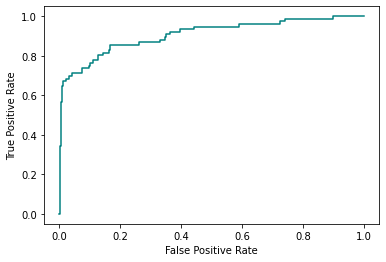

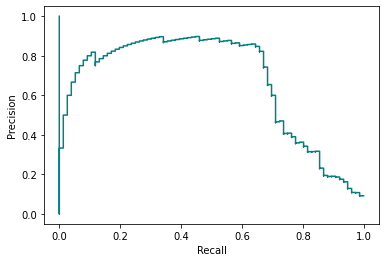

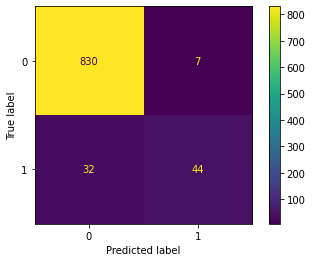

In [89]:
eval_model(model_lr, test_downsampled)

and more importantly, on our scoring set

ROC area under curve Score: 0.8801815642734724
PR area under curve Score: 0.3057940663189113
Confusion Matrix:
[[1581108   10467]
 [   4973    4639]]


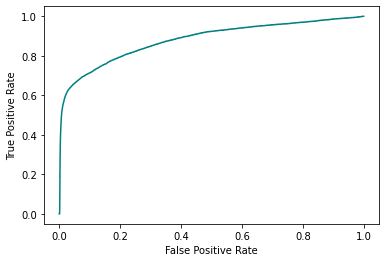

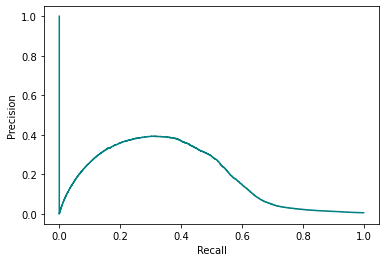

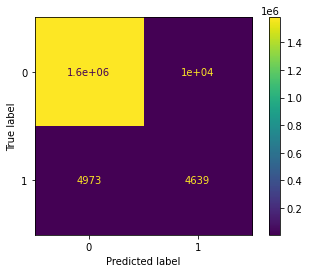

In [90]:
eval_model(model_lr, scoring_df)

The model performs OK on the balanced training set, but its performance drops quite significantly when looking at the unbalanced scoring set.

<a id="dt"></a>
### 1.6.2. Decision Tree Classifier Model


In [91]:
c_dt = DecisionTreeClassifier(featuresCol='features', labelCol='is_fraud')
model_dt = c_dt.fit(train_downsampled)

ROC area under curve Score: 0.9219408287744449
PR area under curve Score: 0.6349315946272849
Confusion Matrix:
[[828   9]
 [ 25  51]]


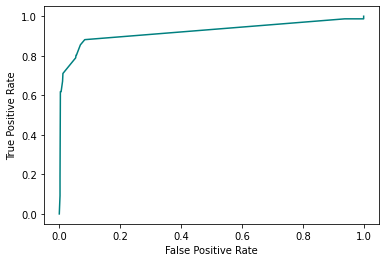

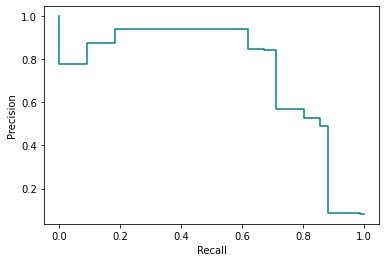

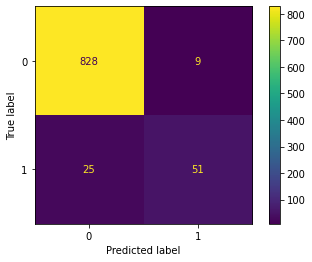

In [92]:
eval_model(model_dt, test_downsampled)

ROC area under curve Score: 0.891963788215895
PR area under curve Score: 0.3743890212454489
Confusion Matrix:
[[1574714   16861]
 [   3779    5833]]


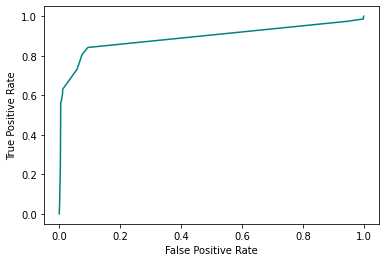

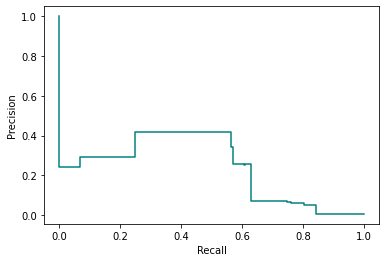

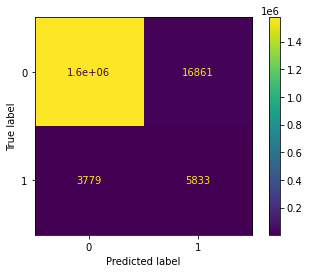

In [93]:
eval_model(model_dt, scoring_df)

<a id="rf"></a>
### 1.6.3. Random Forest Classifier


In [94]:
c_rf = RandomForestClassifier(featuresCol='features', labelCol='is_fraud')
model_rf = c_rf.fit(train_downsampled)

ROC area under curve Score: 0.9750990379173742
PR area under curve Score: 0.7470138032042211
Confusion Matrix:
[[832   5]
 [ 30  46]]


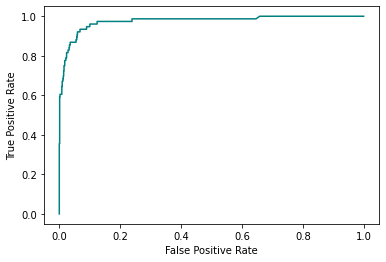

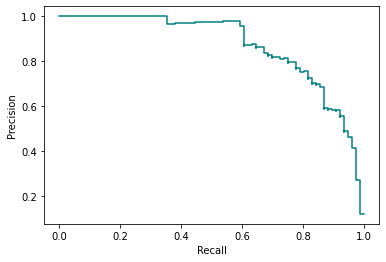

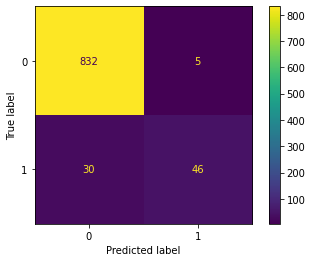

In [95]:
eval_model(model_rf, test_downsampled)

ROC area under curve Score: 0.9586988292473707
PR area under curve Score: 0.48927058625402986
Confusion Matrix:
[[1582015    9560]
 [   3905    5707]]


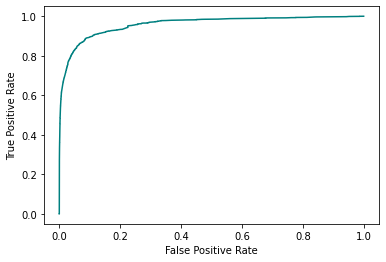

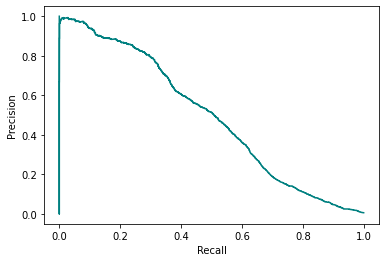

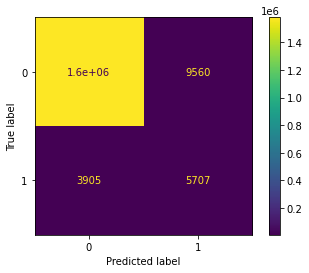

In [96]:
eval_model(model_rf, scoring_df)

<a id="gbt"></a>
### 1.6.4. Gradient Boosted Trees

In [79]:
c_gbt = GBTClassifier(featuresCol='features', labelCol='is_fraud', maxDepth=5, maxIter=200)
model_gbt = c_gbt.fit(train_downsampled)

22/06/15 19:10:27 WARN DAGScheduler: Broadcasting large task binary with size 1001.0 KiB
22/06/15 19:10:27 WARN DAGScheduler: Broadcasting large task binary with size 1003.6 KiB
22/06/15 19:10:27 WARN DAGScheduler: Broadcasting large task binary with size 1004.1 KiB
22/06/15 19:10:27 WARN DAGScheduler: Broadcasting large task binary with size 1004.7 KiB
22/06/15 19:10:28 WARN DAGScheduler: Broadcasting large task binary with size 1005.9 KiB
22/06/15 19:10:28 WARN DAGScheduler: Broadcasting large task binary with size 1008.3 KiB
22/06/15 19:10:28 WARN DAGScheduler: Broadcasting large task binary with size 1011.0 KiB
22/06/15 19:10:28 WARN DAGScheduler: Broadcasting large task binary with size 1011.4 KiB
22/06/15 19:10:28 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
22/06/15 19:10:28 WARN DAGScheduler: Broadcasting large task binary with size 1013.2 KiB
22/06/15 19:10:28 WARN DAGScheduler: Broadcasting large task binary with size 1015.2 KiB
22/06/15 19:10:28 WAR

22/06/15 19:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1479.7 KiB
22/06/15 19:11:23 WARN DAGScheduler: Broadcasting large task binary with size 1482.1 KiB


ROC area under curve Score: 0.9621769477457084
PR area under curve Score: 0.8085279368131776
Confusion Matrix:
[[827  10]
 [ 13  63]]


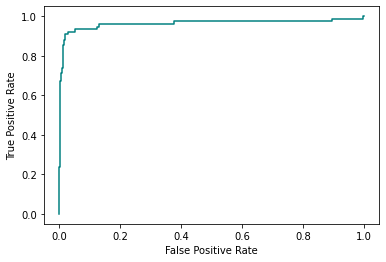

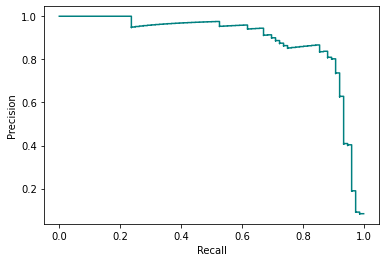

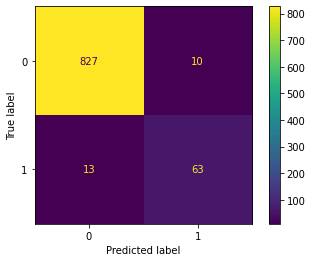

In [80]:
eval_model(model_gbt, test_downsampled)

22/06/15 19:11:26 WARN DAGScheduler: Broadcasting large task binary with size 1434.7 KiB
22/06/15 19:11:33 WARN DAGScheduler: Broadcasting large task binary with size 1436.5 KiB


ROC area under curve Score: 0.9768982802632011
PR area under curve Score: 0.49317791163834057
Confusion Matrix:
[[1573185   18390]
 [   2122    7490]]


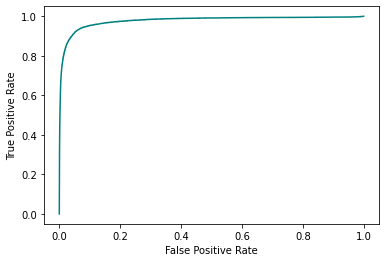

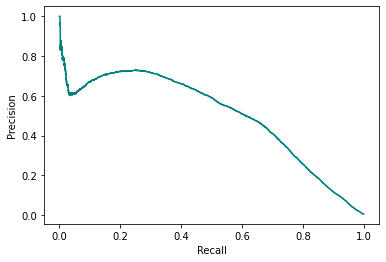

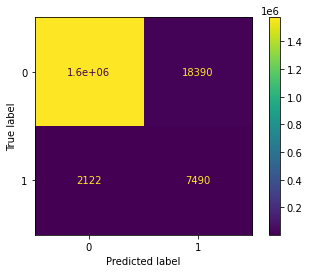

In [81]:
eval_model(model_gbt, scoring_df)

We'll select the Gradient Boosted Tree classsifier because it has the a good balance of ROC under the curve on our balanced test set, and good PR area under curve for the unbalanced scoring set.

<a id="df_training"></a>
## 1.7. Running Training on OCI DataFlow

To run the training on the OCI DataFlow service, we first need to create the application code in one place.

Here we gathered all our helper functions into one cell, with the main() taking a few input parameters. We'll use this file to create the DataFlow application.

The %%writefile Jupyter magic saves the full cell into a single file. We need to define the path to be in what we will define as our dataflow base folder.

In this code, we also fold our data transformation and model training into a single pipeline.

In [5]:
# create the folder
!mkdir -p ./dataflow

In [6]:
dataflow_basefolder = '/home/datascience/workspace/notebooks/dataflow'

<a id="training_script"></a>
### 1.7.1. DataFlow Training Application script

In [28]:
%%writefile {dataflow_basefolder}/fraud_detection_model_training.py
import sys
import os
import numpy as np

# Importing pyspark libraries
from pyspark.conf import SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import FloatType

#test2
    
def is_in_oci():
    return os.environ.get("HOME") == "/home/dataflow" or os.environ.get("HOME") == "/home/datascience"


def get_spark_session(app_name, file_location=None, profile_name=None, spark_config={}):
    """
    Get a Spark session in a way that supports running locally or in Data Flow.
    """
    
    # If we are in DataFlow or DataScience, we assume the instance uses Instance Principal 
    # for authorization, and we can create a Spark Session Builder without config
    if is_in_oci():
        spark_builder = SparkSession.builder.appName(app_name)
        
    # If we run on a local machine, we need to provide authentication from the OCI config
    else:
        # Import OCI.
        try:
            import oci
        except:
            raise Exception(
                "You need to install the OCI python library to test locally"
            )
        # Use defaults for anything unset.
        if file_location is None:
            file_location = oci.config.DEFAULT_LOCATION
        if profile_name is None:
            profile_name = oci.config.DEFAULT_PROFILE

        # Load the config file.
        try:
            oci_config = oci.config.from_file(
                file_location=file_location, profile_name=profile_name
            )
        except Exception as e:
            print("You need to set up your OCI config properly to run locally")
            raise e
        conf = SparkConf()
        conf.set("fs.oci.client.auth.tenantId", oci_config["tenancy"])
        conf.set("fs.oci.client.auth.userId", oci_config["user"])
        conf.set("fs.oci.client.auth.fingerprint", oci_config["fingerprint"])
        conf.set("fs.oci.client.auth.pemfilepath", oci_config["key_file"])
        conf.set(
            "fs.oci.client.hostname",
            "https://objectstorage.\{0\}.oraclecloud.com".format(oci_config["region"]),
        )
        spark_builder = SparkSession.builder.appName(app_name).config(conf=spark_config)

    # Add in extra configuration.
    for key, val in spark_config.items():
        spark_builder.config(key, val)

    # Create the Spark session.
    session = spark_builder.getOrCreate()
    return session


def distance(lat, long, merch_lat, merch_long):

    s_lat, s_lng, e_lat, e_lng = float(lat), float(long), float(merch_lat), float(merch_long)

    # approximate radius of earth in km
    R = 6373.0

    s_lat = s_lat*np.pi/180.0                      
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  

    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

    return float(2 * R * np.arcsin(np.sqrt(d)))


def create_feature_columns(df):
    # Augments the dataset with features we identified
    
    # drop unneeded columns
    df = df.drop('ssn', 'cc_num', 'first', 'last', 'street', 'city', 'state', 
                 'zip', 'job', 'acct_num', 'profile', 'trans_num', 'unix_time', 
                 'merchant')

    # transaction date and time features
    df = df.withColumn('day_of_week', dayofweek(col('trans_date')))
    df = df.withColumn('month_of_year', month(col('trans_date')))
    df = df.withColumn('hour_of_day', hour(col('trans_time')))
    df = df.withColumn('is_weekend', col('day_of_week').isin([1,7]).cast('int'))
    
    # distance
    distance_udf = udf(lambda lat, long, merch_lat, merch_long: distance(lat, long, merch_lat, merch_long), FloatType())
    df = df.withColumn("distance", distance_udf(col('lat'), col('long'), col('merch_lat'), col('merch_long')))
    
    # customer age and gender
    df = df.withColumn('age', floor(datediff(col('trans_date'), to_date(col('dob'), 'yyyy-mm-dd'))/365.25))
    df = df.withColumn('gender', when((col('gender') == 'M'), 1).when((col('gender') == 'F'), 0).otherwise(-1))
    
    # drop no longer used columns
    df = df.drop('dob', 'trans_date', 'trans_time')

    return df


def create_and_fit_model(df):
    # Create a pipeline model encoding categorica features
    # which can be re-used to evaluate the model
    
    # 1-hot encode merchant category
    stringIndexer = StringIndexer(inputCol='category', outputCol='category_index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=['category_classVec'])
    
    # assemble the feature vector with all numerical columns and the category 1-hot encoded column
    numeric_columns = [col[0] for col in df.dtypes if col[1] in ['int', 'double'] and col[0] != 'is_fraud']
    assembler_inputs = ['category_classVec'] + numeric_columns
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

    # define the model
    c_gbt = GBTClassifier(featuresCol='features', labelCol='is_fraud', maxDepth=15, maxIter=20, stepSize=0.05)
    
    # line up the stages for the whole process
    stages = [stringIndexer, encoder, assembler, c_gbt]
    
    # put together the pipeline and fit it
    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(df)
    return pipeline_model


def main(input_data_path, model_output_path, debug, spark_config=None):
    
    sc = get_spark_session(app_name='Fraud Detection Model Training')
    sc.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
    df = sc.read.option("delimiter", "|").csv(input_data_path, header=True, inferSchema=True)

    df = create_feature_columns(df)

    # split into train and test sets
    train, test = df.randomSplit([0.8, 0.2], seed = 2018)
#     if debug == True:
#         print("Training Dataset Count: " + str(train.count()))
#         print("Test Dataset Count: " + str(test.count()))
    
    # downsample the majority class
    train_downsampled = train.sampleBy('is_fraud', fractions = {1: 1, 0: 0.05}, seed= 1234)

    # fit and train the model
    model = create_and_fit_model(train_downsampled)
    
    # write the fitted model to file to use for inference
    model.write().overwrite().save(model_output_path)
    
    if debug == True:
        predictions = model.transform(test)
        predictions.select('age', 'is_fraud', 'rawPrediction', 'prediction', 'probability').show(50)
        evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
        print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

            

if __name__ == "__main__":
    input_data_path = sys.argv[1]
    model_output_path = sys.argv[2]
    debug = False
    if sys.argv[3].lower() == 'true':
        debug = True

    main(input_data_path, model_output_path, debug)



Overwriting /home/datascience/workspace/notebooks/dataflow/fraud_detection_model_training.py


<a id="test_training"></a>
### 1.7.2. Test the DataFlow Application script locally

We can test the application locally by importing our file and running the main function, with proper input values.

In [8]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [9]:
from dataflow.fraud_detection_model_training import main

Let's set our parameters to access the local files and output local files.

In [10]:
data_folder = '/home/datascience/workspace/data/Sparkov_Data_Generation/data/'
file_pattern = 'training set/small/*male*.csv'

model_output_path = 'output/model/small'

Now we can call our `main` function, and we'll pass specific spark_config parameters to run locally.

In [12]:
main(data_folder + file_pattern, model_output_path, debug=True, 
        spark_config={
            'spark.driver.memory': '512g', 
            'spark.executor.memory': '512g'
        })


22/06/14 17:03:37 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863 bytes) of heap memory
Scaling row group sizes to 91.94% for 8 writers
22/06/14 17:03:37 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863 bytes) of heap memory
Scaling row group sizes to 81.72% for 9 writers
22/06/14 17:03:37 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863 bytes) of heap memory
Scaling row group sizes to 91.94% for 8 writers
22/06/14 17:03:37 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863 bytes) of heap memory
Scaling row group sizes to 91.94% for 8 writers
22/06/14 17:03:37 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863 bytes) of heap memory
Scaling row group sizes to 91.94% for 8 writers
22/06/14 17:03:37 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863 bytes) of heap memory
Scaling row group sizes to 81.72% for 9 writers
22/06/14 17:03:37 WARN MemoryManager: Total allocation exceeds 95.00% (987,181,863

+---+--------+--------------------+----------+--------------------+
|age|is_fraud|       rawPrediction|prediction|         probability|
+---+--------+--------------------+----------+--------------------+
| 26|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 26|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 26|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 26|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 26|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 26|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 26|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 26|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 26|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 26|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 26|       0|[1.33507788920967...|       0.0|[0.93524246659636...|
| 26|       0|[1.33507788920967...|       0.0|[0

Test Area Under ROC: 0.9595965174960676


<a id="training_app"></a>
### 1.7.3. Create the DataFlow Application

Using the Oracle ADS package, we have access to simple wrapper functions to create DataFlow applications and associated Runs.

Here we use resource principal to authenticate since we are inside DataScience. On a local machine you should use your OCI config for auth.

In [13]:
ads.set_auth(auth='resource_principal')

we need to set our base folder specifically, so the files will be saved there, and picked up from there to edit-run-edit


In [14]:
data_flow = DataFlow(dataflow_base_folder=dataflow_basefolder)

We're now setting up our parameters matching the program inputs, with path to the files on Object Storage

In [15]:
tenancy_namespace = 'bigdatadatasciencelarge'
bucket_name = 'fraud-detection-data'

script_bucket = 'fraud-detection-dataflow-code'
pyspark_file_path = f'{dataflow_basefolder}/fraud_detection_model_training.py'
logs_bucket = 'fraud-detection-dataflow-logs'

input_data_path = 'oci://fraud-detection-data@bigdatadatasciencelarge/training set/xlarge/*male*.csv'
model_output_path = 'oci://fraud-detection-data@bigdatadatasciencelarge/output/xlarge/model'
debug = 'true'

Now we can prepare our application with the `prepare_app` function:

- `arguments` is a list of arguments passed to the program as if it was run on command line so we pass the variables names defined in script_parameters.

- `script_parameters` contains the default values for these variables.

In [16]:
app_config = data_flow.prepare_app(
                        display_name="Fraud Detection Model Training",
                        script_bucket=script_bucket,
                        pyspark_file_path=pyspark_file_path,
                        logs_bucket=logs_bucket,
                        spark_version='3.0.2',
                        arguments=[
                            "${input_data_path}", 
                            "${model_output_path}", 
                            "${debug}"
                        ],
                        script_parameters={
                         'input_data_path': input_data_path,
                         'model_output_path': model_output_path,
                         'debug': debug
                        })


In [17]:
# if running multiple times, skip this cell, look up the app id, and re-load it
app = data_flow.create_app(app_config, overwrite_script=True, overwrite_archive=True)

loop1:   0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
# latest app we created
data_flow.list_apps()[0].id

'ocid1.dataflowapplication.oc1.phx.anyhqljrnif7xwia27lqns6kecgagqvx3rtafa3inu6xwlauiwmpe62uff7q'

To reload a previous app, use the following replacing the id in the `load_app` function:

In [19]:
# ads.set_auth(auth='resource_principal')
# data_flow = DataFlow(dataflow_base_folder=dataflow_basefolder)
# app = data_flow.load_app(<app_id>)

<a id="training_run"></a>
### 1.7.4. Create a DataFlow Training Run

The app is created with default parameters.

At run-time, we can modify the parameters by passing them as arguments (commented out here):

In [25]:
run_config = app.prepare_run(run_display_name=f"Fraud Detection Model Training {datetime.now()}",
                             num_executors=12,
                             driver_shape='VM.Standard2.16',
                             executor_shape='VM.Standard2.16',
                             input_data_path='oci://fraud-detection-data@bigdatadatasciencelarge/training set/small/*male*.csv',
                             model_output_path= 'oci://fraud-detection-data@bigdatadatasciencelarge/output/small/model',
                             debug=True
                            )

and finally we can launch the run:

In [29]:
ads.set_auth(auth='resource_principal')
data_flow = DataFlow(dataflow_base_folder=dataflow_basefolder)
run = app.run(run_config, save_log_to_local=True, wait=False)
# run = app.run(run_config)

ServiceError: {'opc-request-id': '1886F3AF53A24D8C8C7EBA29EAB1AB1E/FB0041B267AB048E682FD1E38C2DC2A0/B23FB13401791F605DF054004B3996C7', 'code': 'LimitExceeded', 'message': "The resources you have requested for this run exceed the tenant's Data Flow quota limit. The following service limits were exceeded: vm-standard2-16. Request a service limit increase from the service limits page in the console.  Contact your Administrator to increase the limits then resubmit the run or use a different VM shape.", 'status': 400}

<a id="edit_script"></a>
### 1.7.5. Editing DataFlow applications

You can edit the script, and come back to the cell above to create a new run. The script will be automatically synced before the run starts.

Please note that the %%writefile magic tends to take a few seconds to update the script on disk, so take a short pause before re-running the cell above, or the previous version might be picked up.

<a id="df_scoring"></a>
## 1.8. Create a Batch Scoring Application

<a id="scoring_script"></a>
### 1.8.1. DataFlow Batch Scoring Application script

In [43]:
%%writefile {dataflow_basefolder}/fraud_detection_batch_scoring.py
import sys
import os
import numpy as np

# Importing pyspark libraries
from pyspark.conf import SparkConf
from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import FloatType

    
def is_in_oci():
    return os.environ.get("HOME") == "/home/dataflow" or os.environ.get("HOME") == "/home/datascience"


def get_spark_session(app_name, file_location=None, profile_name=None, spark_config={}):
    """
    Get a Spark session in a way that supports running locally or in Data Flow.
    """
    
    # If we are in DataFlow or DataScience, we assume the instance uses Instance Principal 
    # for authorization, and we can create a Spark Session Builder without config
    if is_in_oci():
        spark_builder = SparkSession.builder.appName(app_name)
        
    # If we run on a local machine, we need to provide authentication from the OCI config
    else:
        # Import OCI.
        try:
            import oci
        except:
            raise Exception(
                "You need to install the OCI python library to test locally"
            )
        # Use defaults for anything unset.
        if file_location is None:
            file_location = oci.config.DEFAULT_LOCATION
        if profile_name is None:
            profile_name = oci.config.DEFAULT_PROFILE

        # Load the config file.
        try:
            oci_config = oci.config.from_file(
                file_location=file_location, profile_name=profile_name
            )
        except Exception as e:
            print("You need to set up your OCI config properly to run locally")
            raise e
        conf = SparkConf()
        conf.set("fs.oci.client.auth.tenantId", oci_config["tenancy"])
        conf.set("fs.oci.client.auth.userId", oci_config["user"])
        conf.set("fs.oci.client.auth.fingerprint", oci_config["fingerprint"])
        conf.set("fs.oci.client.auth.pemfilepath", oci_config["key_file"])
        conf.set(
            "fs.oci.client.hostname",
            "https://objectstorage.\{0\}.oraclecloud.com".format(oci_config["region"]),
        )
        spark_builder = SparkSession.builder.appName(app_name).config(conf=spark_config)

    # Add in extra configuration.
    for key, val in spark_config.items():
        spark_builder.config(key, val)

    # Create the Spark session.
    session = spark_builder.getOrCreate()
    return session


def distance(lat, long, merch_lat, merch_long):

    s_lat, s_lng, e_lat, e_lng = float(lat), float(long), float(merch_lat), float(merch_long)

    # approximate radius of earth in km
    R = 6373.0

    s_lat = s_lat*np.pi/180.0                      
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  

    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

    return float(2 * R * np.arcsin(np.sqrt(d)))


def create_feature_columns(df):
    # Augments the dataset with features we identified
    
    # for scoring, we don't drop the original columns: 
    # we may want the original columns in the final output.
    # Columns we need will be picked up by the pipeline
    
    # transaction date and time features
    df = df.withColumn('day_of_week', dayofweek(col('trans_date')))
    df = df.withColumn('month_of_year', month(col('trans_date')))
    df = df.withColumn('hour_of_day', hour(col('trans_time')))
    df = df.withColumn('is_weekend', col('day_of_week').isin([1,7]).cast('int'))
    
    # distance
    distance_udf = udf(lambda lat, long, merch_lat, merch_long: distance(lat, long, merch_lat, merch_long), FloatType())
    df = df.withColumn("distance", distance_udf(col('lat'), col('long'), col('merch_lat'), col('merch_long')))
    
    # customer age and gender
    df = df.withColumn('age', floor(datediff(col('trans_date'), to_date(col('dob'), 'yyyy-mm-dd'))/365.25))
    df = df.withColumn('gender', when((col('gender') == 'M'), 1).when((col('gender') == 'F'), 0).otherwise(-1))
    
    return df


def main(input_data_path, model_path, predictions_output_path, debug, spark_config=None):
    
    # create the session
    sc = get_spark_session(app_name='Fraud Detection Model Training')
    sc.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
    
    # load the data
    df = sc.read.option("delimiter", "|").csv(input_data_path, header=True, inferSchema=True)
    original_cols = df.columns

    print("Dataset Count: " + str(df.count()))

    # augment the dat with tnew columns
    df = create_feature_columns(df)
    
    # load the model
    # edit
    model = PipelineModel.load(model_path)

    # predict
    predictions = model.transform(df)
    
    # show some results
    predictions.select('age', 'is_fraud', 'rawPrediction', 'prediction', 'probability').show(50)
    evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')
    print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
    predictions.printSchema()
    predictions = predictions.select(original_cols + ['prediction'])
    predictions.write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").save(predictions_output_path)

if __name__ == "__main__":
    input_data_path = sys.argv[1]
    model_path = sys.argv[2]
    predictions_output_path = sys.argv[3]
    debug = False
    if sys.argv[4].lower() == 'true':
        debug = True

    main(input_data_path, model_path, predictions_output_path, debug)



Overwriting /home/datascience/workspace/notebooks/dataflow/fraud_detection_batch_scoring.py


In [31]:
script_bucket = 'fraud-detection-dataflow-code'
pyspark_file_path = f'{dataflow_basefolder}/fraud_detection_batch_scoring.py'
logs_bucket = 'fraud-detection-dataflow-logs'

input_data_path = 'oci://fraud-detection-data@bigdatadatasciencelarge/training set/medium/*male*.csv'
model_path = 'oci://fraud-detection-data@bigdatadatasciencelarge/output/xlarge/model'
predictions_output_path = 'oci://fraud-detection-data@bigdatadatasciencelarge/output/medium/predictions/predictions.csv'
debug = 'true'

In [32]:
ads.set_auth(auth='resource_principal')
data_flow = DataFlow(dataflow_base_folder=dataflow_basefolder)

In [33]:
app_config = data_flow.prepare_app(
                        display_name="Fraud Detection Batch Scoring",
                        script_bucket=script_bucket,
                        pyspark_file_path=pyspark_file_path,
                        logs_bucket=logs_bucket,
                        spark_version='3.0.2',
                        arguments=[
                            "${input_data_path}", 
                            "${model_path}", 
                            "${predictions_output_path}",
                            "${debug}"
                        ],
                        script_parameters={
                         'input_data_path': input_data_path,
                         'model_path': model_path,
                         'predictions_output_path': predictions_output_path,
                         'debug': debug
                        })


In [34]:
app = data_flow.create_app(app_config, overwrite_script=True, overwrite_archive=True)

loop1:   0%|          | 0/2 [00:00<?, ?it/s]

or load an existing app:

In [35]:
ads.set_auth(auth='resource_principal')
data_flow = DataFlow(dataflow_base_folder=dataflow_basefolder)
pd.DataFrame(json.loads(str(data_flow.list_apps())))[['display_name', 'id']]

,display_name,id
0,Fraud Detection Batch Scoring,ocid1.dataflowapplication.oc1.phx.anyhqljtnif7...
1,Fraud Detection Model Training,ocid1.dataflowapplication.oc1.phx.anyhqljrnif7...
2,Fraud Detection Batch Scoring,ocid1.dataflowapplication.oc1.phx.anyhqljtnif7...
3,Fraud Detection Model Training,ocid1.dataflowapplication.oc1.phx.anyhqljrnif7...
4,Fraud Detection Batch Scoring,ocid1.dataflowapplication.oc1.phx.anyhqljsnif7...
5,Fraud Detection Model Training,ocid1.dataflowapplication.oc1.phx.anyhqljrnif7...
6,Fraud Detection Model Training,ocid1.dataflowapplication.oc1.phx.anyhqljrnif7...
7,Fraud Detection Batch Scoring,ocid1.dataflowapplication.oc1.phx.anyhqljsnif7...
8,Fraud Detection Model Training,ocid1.dataflowapplication.oc1.phx.anyhqljrnif7...
9,fraud-detection-model-scoring,ocid1.dataflowapplication.oc1.phx.anyhqljrnif7...


In [36]:
# app = data_flow.load_app('ocid1.dataflowapplication.oc1.phx.anyhqljtnif7xwiaidctgsbui4rrjomtju4gpvc2nvcb2ycfwqzk5gcbnvzq')


<a id="scoring_run"></a>
### 1.8.2. Create a DataFlow Run for scoring

In [37]:
run_config = app.prepare_run(run_display_name=f"Fraud Detection Batch Scoring {datetime.now()}",
                             num_executors=2,
                             driver_shape='VM.Standard2.16',
                             executor_shape='VM.Standard2.16',
#                              input_data_path='oci://fraud-detection-data@bigdatadatasciencelarge/training set/medium/*male*.csv',
#                              model_path= 'oci://fraud-detection-data@bigdatadatasciencelarge/output/xlarge/model',
#                              predictions_output_path=f'oci://fraud-detection-data@bigdatadatasciencelarge/output/medium/predictions/predictions-{datetime.now()}.csv',
#                              debug=True
                            )

In [42]:
run = app.run(run_config, save_log_to_local=True, wait=False)

In [ ]:
run.log_stdout.tail()

<a id="model_cat"></a> 
## 1.9. Create a Model in Model Catalog

<a id="artifact"></a>
### 1.9.1. Prepare the Model Artifact for Model Catalog

In [25]:
datetime.now()

datetime.datetime(2022, 6, 17, 22, 12, 37, 56754)

In [26]:
path_to_artifact = f"./fraud-detection-model-deployment"
if not os.path.exists(path_to_artifact):
    os.mkdir(path_to_artifact)

In [27]:
artifact = prepare_generic_model(path_to_artifact, 
                                 fn_artifact_files_included=False, 
                                 force_overwrite=True, 
                                 data_science_env=True,
                                )


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

<a id="model_script"></a>
### 1.9.2. Create the Inference Model script

In [28]:
%%writefile {path_to_artifact}/score.py

import sys
import ocifs
import os
import numpy as np
import json

# Importing pyspark libraries
from pyspark.ml import PipelineModel
from pyspark.ml.classification import GBTClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import FloatType


model_file = 'model'

sc = SparkSession \
    .builder \
    .appName('Fraud Detection Inference') \
    .config('spark.driver.memory', '64g') \
    .config('spark.executor.memory', '64g') \
    .getOrCreate()

fs = ocifs.OCIFileSystem()

def distance(lat, long, merch_lat, merch_long):

    s_lat, s_lng, e_lat, e_lng = float(lat), float(long), float(merch_lat), float(merch_long)

    # approximate radius of earth in km
    R = 6373.0

    s_lat = s_lat*np.pi/180.0                      
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  

    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

    return float(2 * R * np.arcsin(np.sqrt(d)))


def create_feature_columns(df):
    # Augments the dataset with features we identified
        
    # transaction date and time features
    df = df.withColumn('day_of_week', dayofweek(col('trans_date')))
    df = df.withColumn('month_of_year', month(col('trans_date')))
    df = df.withColumn('hour_of_day', hour(col('trans_time')))
    df = df.withColumn('is_weekend', col('day_of_week').isin([1,7]).cast('int'))
    
    # distance
    distance_udf = udf(lambda lat, long, merch_lat, merch_long: distance(lat, long, merch_lat, merch_long), FloatType())
    df = df.withColumn("distance", distance_udf(col('lat'), col('long'), col('merch_lat'), col('merch_long')))
    
    # customer age and gender
    df = df.withColumn('age', floor(datediff(col('trans_date'), to_date(col('dob'), 'yyyy-mm-dd'))/365.25))
    df = df.withColumn('gender', when((col('gender') == 'M'), 1).when((col('gender') == 'F'), 0).otherwise(-1))
    
    return df


def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    
    # Load config file
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    if model_file in contents:
        model = PipelineModel.load(os.path.join(model_dir, model_file))
        return model
    else:
        raise Exception('{0} is not found in model directory {1}'.format(config_file, model_dir))
    


def predict(data, model=load_model()) -> dict:
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: { 'prediction': output from `model.predict` method }

    """
                                    
    if not isinstance(data, list):
        data = [data]

    df = sc.read.json(sc.sparkContext.parallelize(data))

    df_cols = df.columns

    print("Dataset Count: " + str(df.count()))

    df = create_feature_columns(df)

    predictions = model.transform(df)

    results = predictions.select(df_cols + ['prediction']).toJSON().map(json.loads).collect()
    
    return {'predictions': results}


Overwriting ./fraud-detection-model-deployment/score.py


<a id="pull_model"></a>
### 1.9.3. Get the trained model into the model deployment folder

Next we want to get our model generated with the Spark run and saved to object storage, into our model folder. 

We load it and then save it locally.

In [29]:
sc = get_spark_session(app_name='test')
model = PipelineModel.load('oci://fraud-detection-data@bigdatadatasciencelarge/output/xlarge/model')


ERROR:ads:ADS Exception
Traceback (most recent call last):
  File "/home/datascience/conda/pyspark30_p37_cpu_v4/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3524, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3170/1015215132.py", line 1, in <module>
    sc = get_spark_session(app_name='test')
NameError: name 'get_spark_session' is not defined


NameError: name 'get_spark_session' is not defined

In [10]:
model.write().overwrite().save(f'{path_to_artifact}/model')

22/06/14 06:36:12 WARN MemoryManager: Total allocation exceeds 95.00% (928,907,252 bytes) of heap memory
Scaling row group sizes to 98.87% for 7 writers
22/06/14 06:36:12 WARN MemoryManager: Total allocation exceeds 95.00% (928,907,252 bytes) of heap memory
Scaling row group sizes to 86.51% for 8 writers
22/06/14 06:36:12 WARN MemoryManager: Total allocation exceeds 95.00% (928,907,252 bytes) of heap memory
Scaling row group sizes to 76.90% for 9 writers
22/06/14 06:36:12 WARN MemoryManager: Total allocation exceeds 95.00% (928,907,252 bytes) of heap memory
Scaling row group sizes to 86.51% for 8 writers
22/06/14 06:36:12 WARN MemoryManager: Total allocation exceeds 95.00% (928,907,252 bytes) of heap memory
Scaling row group sizes to 98.87% for 7 writers
22/06/14 06:36:12 WARN MemoryManager: Total allocation exceeds 95.00% (928,907,252 bytes) of heap memory
Scaling row group sizes to 86.51% for 8 writers
22/06/14 06:36:12 WARN MemoryManager: Total allocation exceeds 95.00% (928,907,252

<a id="save_to_cat"></a>
### 1.9.4. Save the model into Model Catalog


In [30]:
### Saving the model artifact to the model catalog. 
ads.set_auth(auth='resource_principal')
catalog_entry = artifact.save(display_name=f'fraud-detection-model-{datetime.now()}',
              description='Fraud Detection Model Deployment')

loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_f66245a5-02fe-49af-8dbc-5285f4f21516.zip


<a id="test_model"></a>
### 1.9.5. Test the model locally

We reload the model artifact so it is available locally

In [32]:
artifact.reload()

We'll get some sample data from our other dataset to test the model

In [52]:

delta_data = pd.read_csv('/home/datascience/workspace/data/Sparkov_Data_Generation/data/training set/small/adults_50up_male_urban_80-99.csv', delimiter='|')
input_data = delta_data[15:20].to_json(orient='records')


In [53]:
input_data

'[{"ssn":"300-05-4504","cc_num":4279788191480,"first":"Rodney","last":"Richardson","gender":"M","street":"783 Garcia Village","city":"Louisville","state":"MS","zip":39339,"lat":33.1058,"long":-89.0287,"city_pop":15619,"job":"Firefighter","dob":"1948-07-03","acct_num":959056357132,"profile":"adults_50up_male_urban.json","trans_num":"973e3642c75c14cd199a83108bd9fe09","trans_date":"2013-06-17","trans_time":"23:33:20","unix_time":1371512000,"category":"misc_net","amt":936.35,"is_fraud":1,"merchant":"fraud_Dooley-Thompson","merch_lat":33.651027,"merch_long":-89.637855},{"ssn":"300-05-4504","cc_num":4279788191480,"first":"Rodney","last":"Richardson","gender":"M","street":"783 Garcia Village","city":"Louisville","state":"MS","zip":39339,"lat":33.1058,"long":-89.0287,"city_pop":15619,"job":"Firefighter","dob":"1948-07-03","acct_num":959056357132,"profile":"adults_50up_male_urban.json","trans_num":"7e62101c31d0a2d5edbbab48e30e660b","trans_date":"2013-06-17","trans_time":"23:23:26","unix_time":1

Now we can call the predict method of the model to test locally

In [54]:
artifact.predict(data=input_data)

Dataset Count: 5


22/06/17 23:09:23 WARN DAGScheduler: Broadcasting large task binary with size 21.9 MiB


{'predictions': [{'acct_num': 959056357132,
   'amt': 936.35,
   'category': 'misc_net',
   'cc_num': 4279788191480,
   'city': 'Louisville',
   'city_pop': 15619,
   'dob': '1948-07-03',
   'first': 'Rodney',
   'gender': 1,
   'is_fraud': 1,
   'job': 'Firefighter',
   'last': 'Richardson',
   'lat': 33.1058,
   'long': -89.0287,
   'merch_lat': 33.651027,
   'merch_long': -89.637855,
   'merchant': 'fraud_Dooley-Thompson',
   'profile': 'adults_50up_male_urban.json',
   'ssn': '300-05-4504',
   'state': 'MS',
   'street': '783 Garcia Village',
   'trans_date': '2013-06-17',
   'trans_num': '973e3642c75c14cd199a83108bd9fe09',
   'trans_time': '23:33:20',
   'unix_time': 1371512000,
   'zip': 39339,
   'prediction': 1.0},
  {'acct_num': 959056357132,
   'amt': 844.37,
   'category': 'grocery_pos',
   'cc_num': 4279788191480,
   'city': 'Louisville',
   'city_pop': 15619,
   'dob': '1948-07-03',
   'first': 'Rodney',
   'gender': 1,
   'is_fraud': 1,
   'job': 'Firefighter',
   'last':

In [38]:
catalog_entry.id

'ocid1.datasciencemodel.oc1.phx.amaaaaaanif7xwiadhrwqfg64bzydirrz5zy2ykqmlzmlxf6pcdnl6zwcasa'

In [40]:
catalog_entry.project_id
catalog_entry.compartment_id

'ocid1.compartment.oc1..aaaaaaaa2rbhfgsffu5jytvfscpkw6nywg6ckss7uwo7b4hjaxnhtik2sona'

<a id="md"></a>
## 1.10. Deploy the model

<a id="md_create"></a>
### 1.10.1 Create a Model Deployment and Endpoint

In [41]:
deployer = ModelDeployer()
deployment = deployer.deploy(
    model_id=catalog_entry.id,
    display_name="Fraud Detection Model Deployment",
    instance_shape="VM.Standard2.1",
    instance_count=1,
    project_id=catalog_entry.project_id,
    compartment_id=catalog_entry.compartment_id,
    # The following are optional
#     access_log_group_id="<ACCESS_LOG_GROUP_OCID>",
#     access_log_id="<ACCESS_LOG_OCID>",
#     predict_log_group_id="<PREDICT_LOG_GROUP_OCID>",
#     predict_log_id="<PREDICT_LOG_OCID>",
    wait_for_completion=True,
    max_wait_time=600,
    poll_interval=15
)


loop1:   0%|          | 0/6 [00:00<?, ?it/s]

We can now get the deployment endpoint to test:

In [42]:
deployment.url

'https://modeldeployment.us-phoenix-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.phx.amaaaaaanif7xwiatcbvnm3vaeultgxema5wmihzkut7vpinvpaothdmuw5q'

<a id="test_md"></a>
### 1.10.2 Test the Model Deployment Endpoint

In [55]:
# Use resource principal authentication
auth = oci.auth.signers.get_resource_principals_signer()
endpoint =  f'{deployment.url}/predict'
# endpoint = 'https://modeldeployment.us-phoenix-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.phx.amaaaaaanif7xwiaspqqm4gxlci24s5mb3ajplgchtfeguc3jvgqdwbu4rbq/predict'

# send the POST request and get the response
response = requests.post(endpoint, data=input_data, auth=auth)


We can look at the returned object in json

In [56]:
results = response.json()
results

{'predictions': [{'acct_num': 959056357132,
   'amt': 936.35,
   'category': 'misc_net',
   'cc_num': 4279788191480,
   'city': 'Louisville',
   'city_pop': 15619,
   'dob': '1948-07-03',
   'first': 'Rodney',
   'gender': 1,
   'is_fraud': 1,
   'job': 'Firefighter',
   'last': 'Richardson',
   'lat': 33.1058,
   'long': -89.0287,
   'merch_lat': 33.651027,
   'merch_long': -89.637855,
   'merchant': 'fraud_Dooley-Thompson',
   'profile': 'adults_50up_male_urban.json',
   'ssn': '300-05-4504',
   'state': 'MS',
   'street': '783 Garcia Village',
   'trans_date': '2013-06-17',
   'trans_num': '973e3642c75c14cd199a83108bd9fe09',
   'trans_time': '23:33:20',
   'unix_time': 1371512000,
   'zip': 39339,
   'prediction': 1.0},
  {'acct_num': 959056357132,
   'amt': 844.37,
   'category': 'grocery_pos',
   'cc_num': 4279788191480,
   'city': 'Louisville',
   'city_pop': 15619,
   'dob': '1948-07-03',
   'first': 'Rodney',
   'gender': 1,
   'is_fraud': 1,
   'job': 'Firefighter',
   'last':

Note: if at this point you are getting an error `Authorization failed or requested resource not found.`, 
try the request again as you may have called the endpoint too soon.
    

For a more readable output of the predictions, we can create a pandas dataframe with the data:

In [57]:
df = pd.DataFrame(results['predictions'])

In [58]:
df.head(10)

,acct_num,amt,category,cc_num,city,city_pop,dob,first,gender,is_fraud,...,profile,ssn,state,street,trans_date,trans_num,trans_time,unix_time,zip,prediction
0,959056357132,936.35,misc_net,4279788191480,Louisville,15619,1948-07-03,Rodney,1,1,...,adults_50up_male_urban.json,300-05-4504,MS,783 Garcia Village,2013-06-17,973e3642c75c14cd199a83108bd9fe09,23:33:20,1371512000,39339,1.0
1,959056357132,844.37,grocery_pos,4279788191480,Louisville,15619,1948-07-03,Rodney,1,1,...,adults_50up_male_urban.json,300-05-4504,MS,783 Garcia Village,2013-06-17,7e62101c31d0a2d5edbbab48e30e660b,23:23:26,1371511406,39339,1.0
2,959056357132,904.11,shopping_net,4279788191480,Louisville,15619,1948-07-03,Rodney,1,1,...,adults_50up_male_urban.json,300-05-4504,MS,783 Garcia Village,2013-06-18,e60e7f187a2e9971a80e4931f58eff63,18:29:38,1371580178,39339,1.0
3,959056357132,54.76,grocery_pos,4279788191480,Louisville,15619,1948-07-03,Rodney,1,0,...,adults_50up_male_urban.json,300-05-4504,MS,783 Garcia Village,2012-06-20,21871263f6911f07299c965013809948,03:43:32,1340163812,39339,0.0
4,959056357132,69.77,gas_transport,4279788191480,Louisville,15619,1948-07-03,Rodney,1,0,...,adults_50up_male_urban.json,300-05-4504,MS,783 Garcia Village,2012-02-28,9b882c94040cfb38cc84c2f91d14d656,11:53:17,1330429997,39339,0.0


You are done: you explored the data, created a model, trained it on a large dataset, then created a batch inference application you can call on demand, and a real-time inference server you can call with the REST endpoint.

<a id="reference"></a>
# References

**TODO: You must include these links:**

- [ADS Library Documentation](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)

**TODO: Provide any other links that help the customer get information about the conda. This may be links to related technology, blog posts, documentation, and the libraries.**

* [Understanding Conda Environments](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/use-notebook-sessions.htm#conda_understand_environments)
* [Use Resource Manager to Configure Your Tenancy for Data Science](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/orm-configure-tenancy.htm)